# Using EMC² to Process E3SMv3 Output using New E3SMv3 Model Class
---

#### EMC² can be used to simulate radar and lidar observables faithful to large-scale model physics. Here, we will demonstrate using EMC² to evaluate a climate model's output. We will process E3SM regional output around the fixed ARM site at Utqiagvik, North Slope of Alaska site, using EMC² radiation approach (fastest processing; faithful to E3SM's radiation logic; similar general approach to that used for the on-line COSP). 
#### We will briefly explore:
1. Reading model output file using EMC²
1. Generating subcolumns and running the radar and lidar instrument simualtors
1. Classifying the simulator output
1. Plotting the simulated observables to evaluate the model output

## Imports

In [1]:
import emc2
import numpy as np
import xarray as xr

## Initializing Instrument Class Objects

#### We begin with generating instrument class objects representing instruments deployed at Utqiagvik; that is, high spectral resolution lidar (HSRL) `emc2.core.instruments.HSRL` and ARM Ka-band Zenith Radar (KAZR) `emc2.core.instruments.KAZR` objects. Among other radar and lidar instruments, EMC² includes instrument sub-classes for the full ARM radar and lidar instrument suite. Note that in the case of the KAZR class object (as in the case of different radar object) we specify the ARM site string to initialize the KAZR class object with the correct radar attributes.

In [2]:
# Set instrument class objects to simulate (a radar and a lidar)
KAZR = emc2.core.instruments.KAZR('nsa')
HSRL = emc2.core.instruments.HSRL()
print("Instrument class generation done!")

Instrument class generation done!


## Initializing a Model Class Object

#### Let's take a look at the model output data file from EAM (E3SM's atmospheric component) using the `xarray` Python package.

In [3]:
# Path to E3SM output file
model_path = './example_data/e3smv3_comble_anx.2020-03-01.demo.nc'
xr.open_dataset(model_path)

<xarray.Dataset>
Dimensions:                  (ncol: 1, lev: 80, ilev: 81, P3_input_dim: 16,
                              P3_output_dim: 32, time: 1489, nbnd: 2)
Coordinates:
  * lev                      (lev) float64 0.1236 0.1819 0.2674 ... 993.8 998.5
  * ilev                     (ilev) float64 0.1 0.1472 0.2166 ... 997.0 1e+03
  * P3_input_dim             (P3_input_dim) int32 1 2 3 4 5 6 ... 12 13 14 15 16
  * P3_output_dim            (P3_output_dim) int32 1 2 3 4 5 ... 28 29 30 31 32
  * time                     (time) datetime64[ns] 2020-03-01 ... 2020-04-01
Dimensions without coordinates: ncol, nbnd
Data variables: (12/236)
    lat                      (ncol) float64 ...
    lon                      (ncol) float64 ...
    area                     (ncol) float64 ...
    hyam                     (lev) float64 ...
    hybm                     (lev) float64 ...
    P0                       float64 ...
    ...                       ...
    vap_ice_exchange         (time, lev, ncol) float32 ...
    vap_liq_exchange         (time, lev, ncol) float32 ...
    vap_liq_exchange_clubb   (time, lev, ncol) float32 ...
    wat_a1                   (time, lev, ncol) float32 ...
    wat_a2                   (time, lev, ncol) float32 ...
    wat_a3                   (time, lev, ncol) float32 ...
Attributes: (12/19)
    ne:                4
    np:                4
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         2111bf90cb
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@llnl.gov
    initial_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/ea...
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    time_period_freq:  minute_30

#### Instead of explicitly using the xarray package to load the data, EMC² can automatically load the data file when generating an `emc2.core.model.E3SM` object. By using EMC² to load a large-scale model's output, we are able to handle 2 potential issues exemplified in the examined E3SM output file:
1. Because E3SM operates a cube-sphere grid, data is not provided in a strict lat-lon grid (two spatial dimensions) but rather on a column basis (one spatial dimension). We need to inform EMC² about that by setting `all_appended_in_lat=True`.
1. The regional output file has appended strings at the end of every field name, the result of post-processing machinery. By setting `appended_str=True`, EMC² can remove these strings by using one of EMC²'s internal methods invoked during initialization.

#### Let's generate an `emc2.core.model.E3SM` object and examine how the loaded data file is shown after initialization as an `xr.Dataset` object.

In [4]:
# Set model class object to use and load output file.
my_e3sm = emc2.core.model.E3SMv3(model_path, all_appended_in_lat=True, appended_str=True, single_ice_class=True, include_rain_in_rt=False)
my_e3sm.ds  # shows the loaded dataset

no dimension name with an appended string found


<xarray.Dataset>
Dimensions:                  (lev: 80, ilev: 81, P3_input_dim: 16,
                              P3_output_dim: 32, time: 1489, nbnd: 2)
Coordinates:
  * lev                      (lev) float64 998.5 993.8 986.2 ... 0.1819 0.1236
  * ilev                     (ilev) float64 0.1 0.1472 0.2166 ... 997.0 1e+03
  * P3_input_dim             (P3_input_dim) int32 1 2 3 4 5 6 ... 12 13 14 15 16
  * P3_output_dim            (P3_output_dim) int32 1 2 3 4 5 ... 28 29 30 31 32
  * time                     (time) datetime64[ns] 2020-03-01 ... 2020-04-01
Dimensions without coordinates: nbnd
Data variables: (12/239)
    lat                      float64 dask.array<chunksize=(), meta=np.ndarray>
    lon                      float64 dask.array<chunksize=(), meta=np.ndarray>
    area                     float64 dask.array<chunksize=(), meta=np.ndarray>
    hyam                     (lev) float64 0.0003352 0.001392 ... 0.0001236
    hybm                     (lev) float64 0.9982 0.9924 0.9831 ... 0.0 0.0 0.0
    P0                       float64 ...
    ...                       ...
    wat_a1                   (time, lev) float32 5.049e-10 3.974e-10 ... 0.0 0.0
    wat_a2                   (time, lev) float32 8.167e-12 6.508e-12 ... 0.0 0.0
    wat_a3                   (time, lev) float32 7.364e-09 5.734e-09 ... 0.0 0.0
    p_3d                     (time, lev) float64 dask.array<chunksize=(1489, 80), meta=np.ndarray>
    zeros_cf                 (time, lev) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rho_a                    (time, lev) float64 dask.array<chunksize=(1489, 80), meta=np.ndarray>
Attributes: (12/23)
    ne:                   4
    np:                   4
    title:                EAM History file information
    source:               E3SM Atmosphere Model
    source_id:            2111bf90cb
    product:              model-output
    ...                   ...
    topography_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-...
    time_period_freq:     minute_30
    _file_dates:          ['20200301']
    _file_times:          ['000000']
    _datastream:          act_datastream
    _arm_standards_flag:  0

## Running the Subcolumn Generator and Instrument Simulator

#### Now, we use the `emc2.simulator.main.make_simulated_data` method to have EMC² perform a set of (optional) tasks:
1. Generate user-specified number of subcolumns per model grid cell.
1. Run the instrument simualtor.
1. Classify hydrometeor phase using the simulated observables.

#### We first call the `emc2.simulator.main.make_simulated_data` method to calculate the HSRL observables and then call it again to calcualte the KAZR observables (without invoking the subcolumn generator methods again). 
#### Note that because the model output contains the spatial dimension stacked onto the time dimension, we wish to unstack these dimensions once all simualtor operations are done by setting `unstack_dims=True`. 
* because the simulator is being run here using a 10-yr old machine, the processing timing printed on the screen is relatively longer than one should typically expect. 

In [5]:
#Specify number of subcolumns and run simulator (first, for the lidar, then the radar) 
N_sub = 10
my_e3sm = emc2.simulator.main.make_simulated_data(my_e3sm, HSRL, N_sub, do_classify=True, convert_zeros_to_nan=True,
                                                 use_rad_logic=True)
print("lidar processing done!")
my_e3sm = emc2.simulator.main.make_simulated_data(my_e3sm, KAZR, N_sub, do_classify=True, convert_zeros_to_nan=True,
                                                   unstack_dims=True, skip_subcol_gen=True, finalize_fields=True, 
                                                   use_rad_logic=True)
print("radar processing done!")

## Creating subcolumns...
No convective processing for E3SMv3
Now performing parallel stratiform hydrometeor allocation in subcolumns
Fully overcast cl & ci in 2712 voxels
Done! total processing time = 5.59s
Now performing parallel strat precipitation allocation in subcolumns
Fully overcast pl & pi in 0 voxels
Done! total processing time = 3.09s
Generating lidar moments...
Generating stratiform lidar variables using radiation logic
2-D interpolation of bulk liq lidar backscattering using mu-lambda values
2-D interpolation of bulk liq lidar extinction using mu-lambda values
Done! total processing time = 0.43s
'pl' not in hyd_types = ['cl', 'ci']; excluding from COSP calculations
'pi' not in hyd_types = ['cl', 'ci']; excluding from COSP calculations
lidar processing done!
## Creating subcolumns...
Skipping subcolumn generator (make sure subcolumns were already generated).
Generating radar moments...
Generating stratiform radar variables using radiation logic
2-D interpolation of bulk liq

#### We can examine the simulator output dataset saved under an `xr.Dataset` object. We can see that for most lidar and radar observables (the equivalent reflectivity factor Ze, the backscatter cross-section beta_p, etc.) we have fields per hydrometeor class in addition to the field representing the total.

In [6]:
my_e3sm.ds

<xarray.Dataset>
Dimensions:                           (lev: 80, ilev: 81, P3_input_dim: 16,
                                       P3_output_dim: 32, time: 1489, nbnd: 2,
                                       subcolumn: 10)
Coordinates:
  * lev                               (lev) float64 998.5 993.8 ... 0.1236
  * ilev                              (ilev) float64 0.1 0.1472 ... 997.0 1e+03
  * P3_input_dim                      (P3_input_dim) int32 1 2 3 4 ... 14 15 16
  * P3_output_dim                     (P3_output_dim) int32 1 2 3 4 ... 30 31 32
  * time                              (time) datetime64[ns] 2020-03-01 ... 20...
  * subcolumn                         (subcolumn) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: nbnd
Data variables: (12/294)
    lat                               float64 dask.array<chunksize=(), meta=np.ndarray>
    lon                               float64 dask.array<chunksize=(), meta=np.ndarray>
    area                              float64 dask.array<chunksize=(), meta=np.ndarray>
    hyam                              (lev) float64 0.0003352 ... 0.0001236
    hybm                              (lev) float64 0.9982 0.9924 ... 0.0 0.0
    P0                                float64 ...
    ...                                ...
    sub_col_Ze_att_tot_strat          (subcolumn, time, lev) float64 nan ... nan
    Ze_min                            (time, lev) float32 -64.79 ... -13.64
    sub_col_Ze_tot                    (subcolumn, time, lev) float64 nan ... nan
    sub_col_Ze_att_tot                (subcolumn, time, lev) float64 nan ... nan
    detect_mask                       (time, lev, subcolumn) bool False ... F...
    phase_mask_KAZR_sounding_all_hyd  (subcolumn, time, lev) float64 nan ... nan
Attributes: (12/23)
    ne:                   4
    np:                   4
    title:                EAM History file information
    source:               E3SM Atmosphere Model
    source_id:            2111bf90cb
    product:              model-output
    ...                   ...
    topography_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-...
    time_period_freq:     minute_30
    _file_dates:          ['20200301']
    _file_times:          ['000000']
    _datastream:          act_datastream
    _arm_standards_flag:  0

## Visualization

#### We can plot EMC² output using matplotlib, xarray's internal methods, or EMC²'s `emc2.plotting.SubcolumnDisplay` object, which is based on the [ACT](https://arm-doe.github.io/ACT/) package. Here, using the `SubcolumnDisplay`'s `plot_subcolumn_timeseries` method, we show the height x time curtain of the first subcolumn (out of the 50 specified) in the grid cell closest to the coordinates of the Utqiagvik specified using the `lat_sel` and `lon_sel` keywords. The hatch patterns invoked by setting `hatched_mask=True`, designate subcolumn bins not detected by the simulated instrument.

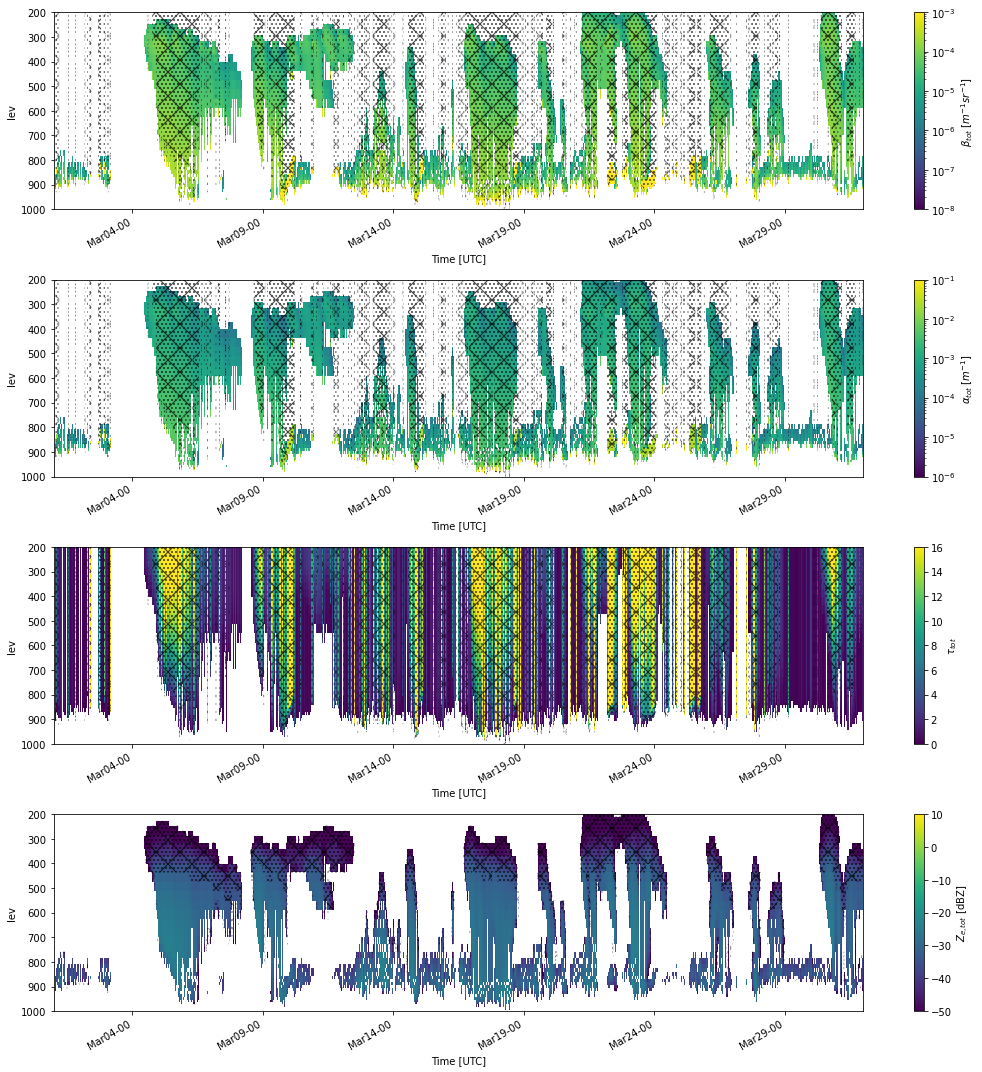

In [7]:
# Set input parameters.
cmap = 'viridis'
field_to_plot = ["sub_col_beta_p_tot", "sub_col_alpha_p_tot", "sub_col_OD_tot", "sub_col_Ze_att_tot"]
vmin_max = [(1e-8,1e-3), (1e-6, 1e-1), (0, 16), (-50., 10.)]
log_plot = [True, True, False, False]
is_radar_field = [False, False, False, True]
y_range = (200., 1e3)  # in hPa
subcol_ind = 0
ANX_coords = {"lat": 70.6, "lon": 14.9}

# Generate a SubcolumnDisplay object for coords closest to the NSA site
model_display = emc2.plotting.SubcolumnDisplay(my_e3sm, subplot_shape=(4, 1), figsize=(15,15),
                                               lat_sel=ANX_coords["lat"],
                                               lon_sel=ANX_coords["lon"], 
                                               tight_layout=True)

# set intrument detectability masks for KAZR and HSRL
Mask_array_KAZR_model = model_display.model.ds["detect_mask"].isel(subcolumn=subcol_ind)
Mask_array_HSRL_model = model_display.model.ds["ext_mask"].isel(subcolumn=subcol_ind)

# Plot variables
for ii in range(4):
    if is_radar_field[ii]:
        Mask_array=Mask_array_KAZR_model
    else:
        Mask_array=Mask_array_HSRL_model
    model_display.plot_subcolumn_timeseries(field_to_plot[ii], subcol_ind, log_plot=log_plot[ii], y_range=y_range,
                                            subplot_index=(ii),  cmap=cmap, title='',
                                            vmin=vmin_max[ii][0], vmax=vmin_max[ii][1],
                                            Mask_array=Mask_array, hatched_mask=True)

#### For a given subcolumn, we can also plot the output from one of the phase classification algorithms (HSRL-based classification in this case) by using the `plot_subcolumn_timeseries` method followed by calling the `change_plot_to_class_mask`.
#### Another option is to use the phase classification output and the `emc2.simulator.classification.calculate_phase_ratio` method to calcualte the hydrometeor phase partitioning based on all subcolumns, which we can then plot. Here, we also use the `SubcolumnDisplay`'s `fig.savefig` method to save the figure as a PNG file.

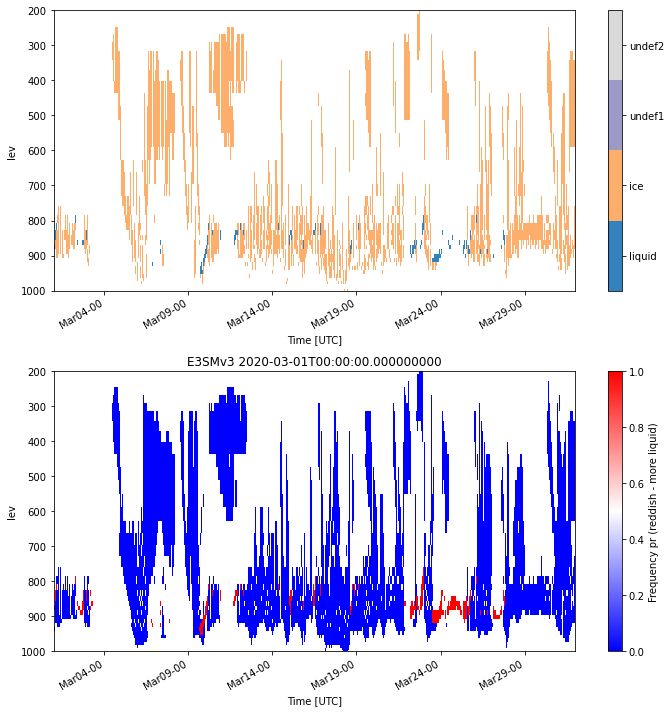

In [8]:
# Calculate frequency phase ratio
my_e3sm = emc2.simulator.classification.calculate_phase_ratio(my_e3sm, "phase_mask_HSRL_all_hyd", [1])

# Generate a SubcolumnDisplay object for coords closest to the NSA site
model_display2 = emc2.plotting.SubcolumnDisplay(my_e3sm, subplot_shape=(2, 1), figsize=(10,10),
                                               lat_sel=ANX_coords["lat"],
                                               lon_sel=ANX_coords["lon"], 
                                               tight_layout=True)

# Plot classification mask output for a given subcolumn
_, cb2_1 = model_display2.plot_subcolumn_timeseries("phase_mask_HSRL_all_hyd", subcol_ind, y_range=y_range,
                                        subplot_index=(0),  title='')
model_display2.change_plot_to_class_mask(cb2_1, variable="phase_mask_HSRL_all_hyd", convert_zeros_to_nan=True)

# Plot frequency phase ratio based on simulated data from all subcolumns
model_display2.plot_subcolumn_timeseries("phase_mask_HSRL_all_hyd_fpr", subcol_ind, y_range=y_range,
                                         cmap="bwr", subplot_index=(1),
                                         cbar_label='Frequency pr (reddish - more liquid)')
model_display2.fig.savefig('HSRL_simulated_class.png', dpi=150)

#### Recalling that EMC² outputs radar and lidar observables per hydrometeor class, we can examine a breakdown of hydrometeor contribution to every simulated observable. This type of analysis also enables the evaluation of the classification algorithm, generally speaking. Note that because we examine variables per hydrometeor class, we ignore the detectability constraints here. Also note that the user can quite easily edit the "cosmetics" (fontsize, etc.) when calling the plotting method, but we skip these options in this example.

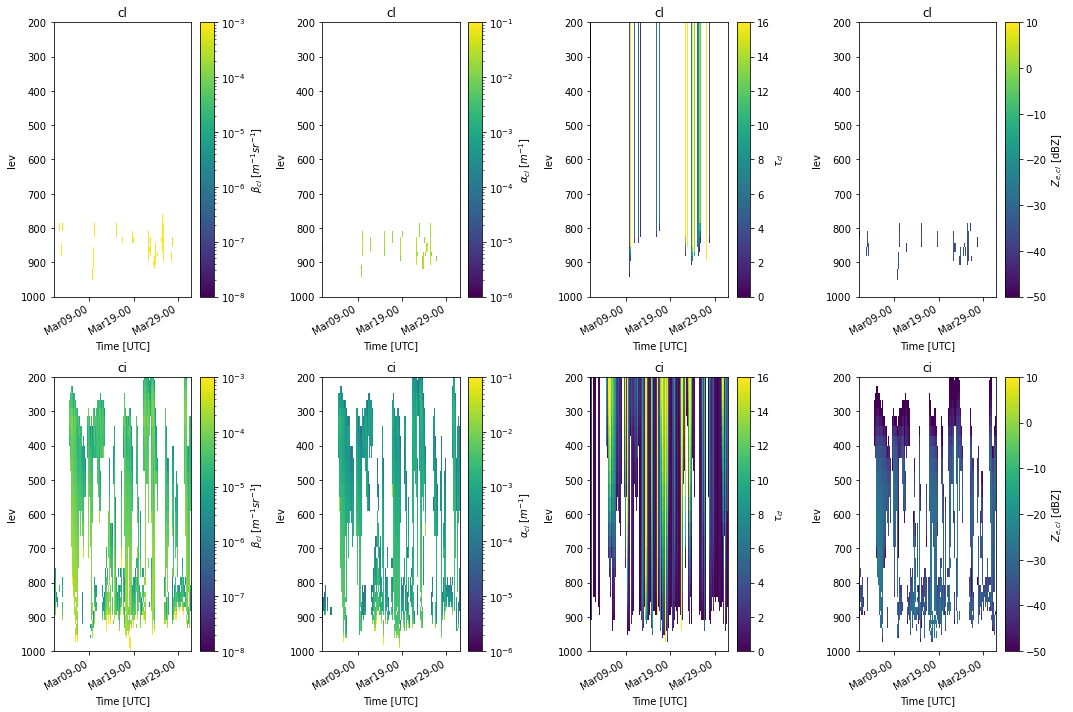

In [9]:
# Set additional input parameters.
field_to_plot_per_class = \
    ["sub_col_beta_p_%s_strat", "sub_col_alpha_p_%s_strat", "sub_col_OD_%s_strat", "sub_col_Ze_%s_strat"]
hyd_class = my_e3sm.hyd_types

# generate a SubcolumnDisplay object for coords closest to the NSA site.
model_display3 = emc2.plotting.SubcolumnDisplay(my_e3sm, subplot_shape=(len(hyd_class), 4), figsize=(15, 5 * len(hyd_class)),
                                               lat_sel=ANX_coords["lat"],
                                               lon_sel=ANX_coords["lon"], 
                                               tight_layout=True)

# Plot variables per hydrometeor class
for ii in range(4):
    for class_i in range(len(hyd_class)):
        if is_radar_field[ii]:
            Mask_array=Mask_array_KAZR_model
        else:
            Mask_array=Mask_array_HSRL_model
        model_display3.plot_subcolumn_timeseries(field_to_plot_per_class[ii] % hyd_class[class_i], subcol_ind,
                                                log_plot=log_plot[ii], y_range=y_range,
                                                subplot_index=(class_i, ii),  cmap=cmap, title=hyd_class[class_i],
                                                vmin=vmin_max[ii][0], vmax=vmin_max[ii][1])

#### In addition to plotting the temporal evolution of a specific subcolun, we can also plot all subcolumns at a single time step using the `SubcolumnDisplay`'s `plot_single_profile` method.

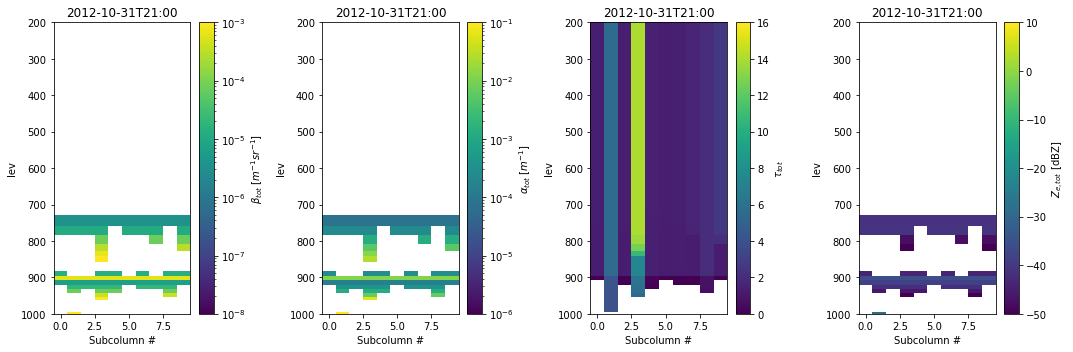

In [10]:
# Specify time step to examine
Time = np.array('2012-10-31T21:00', dtype='datetime64')

# generate a SubcolumnDisplay object for coords closest to the NSA site.
model_display4 = emc2.plotting.SubcolumnDisplay(my_e3sm, subplot_shape=(1, 4), figsize=(15, 5),
                                               lat_sel=ANX_coords["lat"], 
                                               lon_sel=ANX_coords["lon"],
                                               tight_layout=True)

# Plot variables at a given time step.
for ii in range(4):
    model_display4.plot_single_profile(field_to_plot[ii], time=Time, log_plot=log_plot[ii], y_range=y_range,
                                            subplot_index=(0, ii),  cmap=cmap, title=Time,
                                            vmin=vmin_max[ii][0], vmax=vmin_max[ii][1])

#### We can also examine mean profiles using the `plot_subcolumn_mean_profile` method. This method also illustrates the stardard deviation as an envelope around the mean. Note that here we plot the mean profile as a function of height instead of pressure coordinates by setting `pressure_coords=False` when invoking the plotting routine.

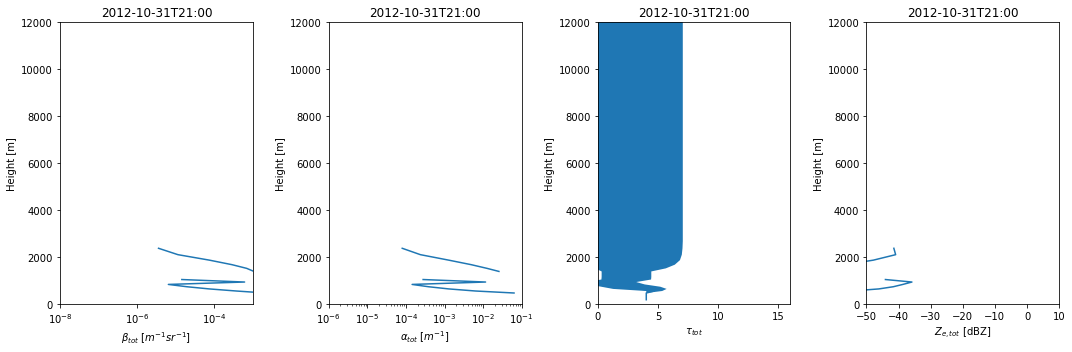

In [11]:
# Specify height range to plot (previously we plotted the pressure level on the y-axis)
y_range_h = (0., 12000)

# generate a SubcolumnDisplay object for coords closest to the NSA site
model_display5 = emc2.plotting.SubcolumnDisplay(my_e3sm, subplot_shape=(1, 4), figsize=(15, 5),
                                               lat_sel=ANX_coords["lat"], 
                                               lon_sel=ANX_coords["lon"],
                                               tight_layout=True)

# Plot variable mean profiles
for ii in range(4):
    model_display5.plot_subcolumn_mean_profile(field_to_plot[ii], time=Time, log_plot=log_plot[ii], y_range=y_range_h,
                                              subplot_index=(0, ii),  title=Time, pressure_coords=False,
                                              x_range=vmin_max[ii])

## Concluding Remarks

#### EMC² includes support for a large number of instruments including the full ARM radar and lidar instrument suite and has already been operated on ESM, SCM, and LES outputs. The software include multiple methods for phase classification and partitioning, scattering calculations, and more. See and follow the continuously updated [EMC² GitHub repository](https://github.com/columncolab/EMC2) for more information.

## Resources and References

- [The EMC² manuscript (Silber et al. GMD, 2022)](https://doi.org/10.5194/gmd-15-901-2022)
- [EMC² documentation](https://columncolab.github.io/EMC2/)
- [EMC² source code](https://github.com/columncolab/EMC2)